In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cmdstanpy
from scipy.optimize import minimize
from IPython.display import Image
import arviz as az
import seaborn as sns

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['figure.figsize'] = (11, 7)

bayesian linear regression
statistical model and pgms
priors and likelihood
prior predictive checks
mcmc
posterior samples
posterior predictive checks

# reading models

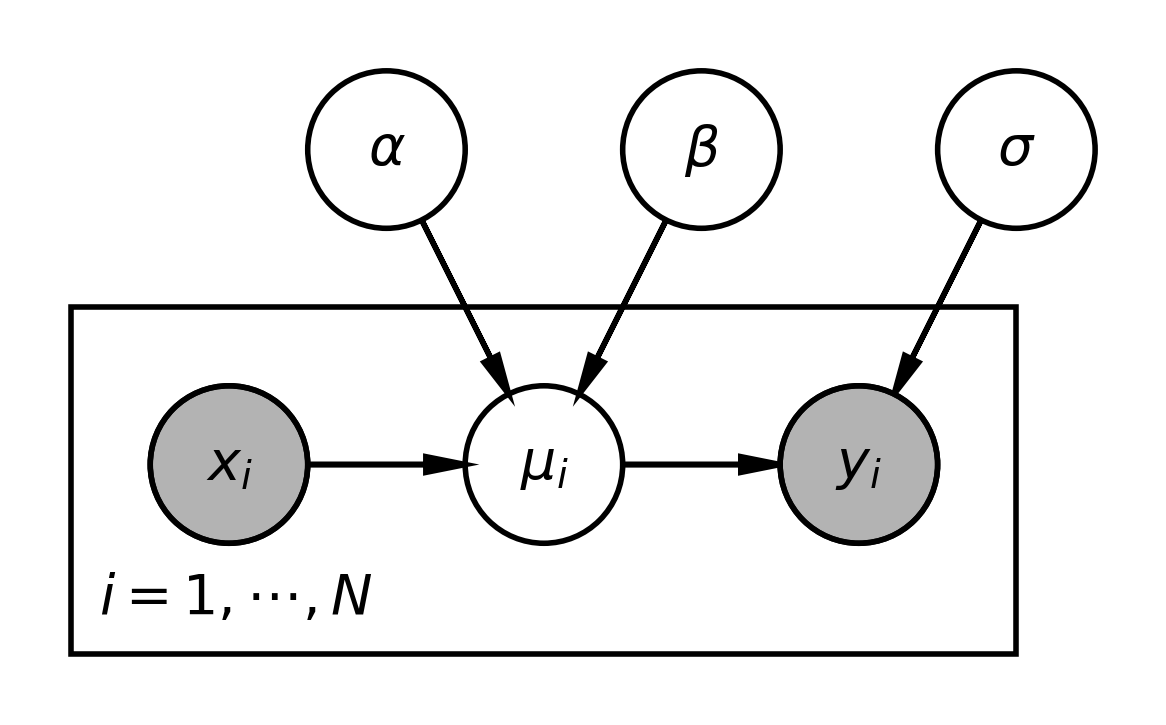

In [2]:
Image("pgm.png", embed=True, width=800, height=700)

### Likelihood (preferred notation):
\begin{align}
    y_i \sim \mathcal{N}(\mu_i, \sigma) \\
    \mu_i = \alpha + \beta \, x_i \\
\end{align}
### or:
\begin{align}
    y_i = \mu_i + \epsilon_i \\
    \epsilon_i \sim \mathcal{N}(0, \sigma) \\
\end{align}

### Priors:
\begin{align}
    \alpha \sim \mathcal{N}(0, 1) \\
    \beta \sim \mathcal{N}(0, 1) \\
    \sigma \sim Exp\,(1) \\
\end{align}

Text(0, 0.5, 'y')

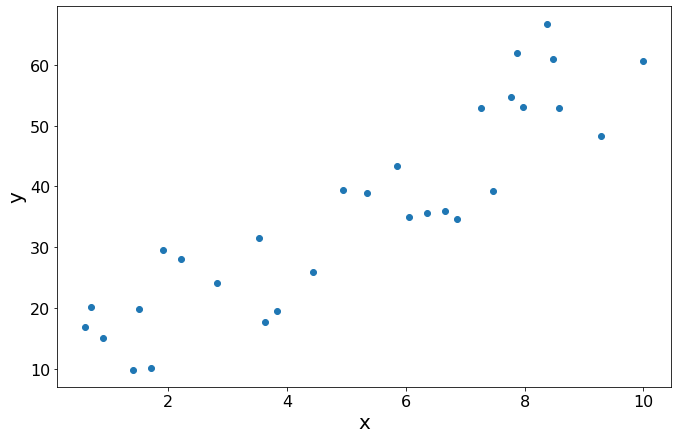

In [64]:
# generate some data
n = 30
x = np.random.choice(np.linspace(0, 10, 100), size=n, replace=False)
x = np.sort(x)

# true values that we want to recover
a = 10
b = 5
s = 7

# simulate some observations
mu = a + b * x
y = np.random.normal(mu, s)

# clamp at 0, maybe y is something physical that can't be negative (e.g. weight, height)
y = np.maximum(y, 0)

# plot the data
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')

# mle

### Gaussian likelihood:

\begin{align}
    f(y | x, m, b, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \, \exp\left(-\frac{(y - (mx + b))^2}{2\sigma^2}\right)
\end{align}

For $i = 1 \cdots N$, $y_i \sim N(\mu_i, \sigma)$. Assuming the $y_i$'s are **iid**, multiply all the likelihoods:

\begin{align}
    f(y_1, \cdots, y_n | x_1, \cdots, x_n, m, b, \sigma) = \prod_{i = 1}^{N} f(y_i | x_i, m, b, \sigma)
\end{align}

In practice, we tend to use **log likelihoods** for simplicity and stability. Since log is a strictly increasing function, maximizing the likelihood is the same as maximizing the log likelihood. The log likelihood is:

\begin{align}
    \mathcal{L} = -\frac{n}{2} \ln(2 \pi \sigma^2) - \frac{\sum_{i=1}^{N} (y_i - (mx_i + b))^2}{2 \sigma^2}
\end{align}

In [65]:
def ln_likelihood(theta: (float, float, float), x: np.ndarray, y: np.ndarray) -> float:
    assert x.size == y.size
    n = x.size
    m, b, sigma = theta
    mu = m * x + b
    return -n / 2 * np.log(2 * np.pi * sigma**2) - np.sum((y - mu)**2) / (2 * sigma**2)

In [66]:
nll = lambda *args: -ln_likelihood(*args)
guess = (1, 1, 1)
theta = minimize(nll, guess, args=(x, y))
mle_params = theta.x
mle_params

array([5.13784889, 9.63337388, 7.09854659])

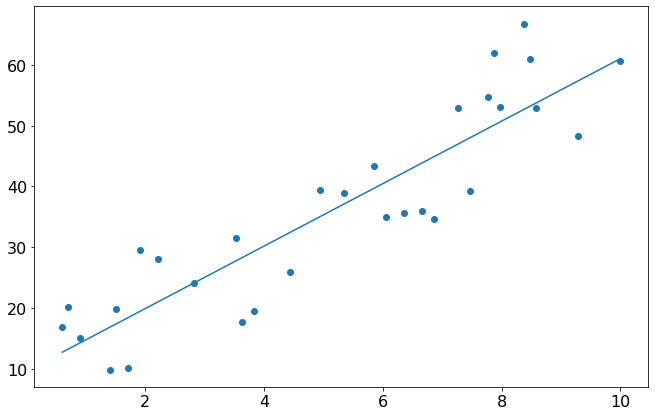

In [67]:
plt.scatter(x, y)
plt.plot(x, x * mle_params[0] + mle_params[1])

# choosing priors

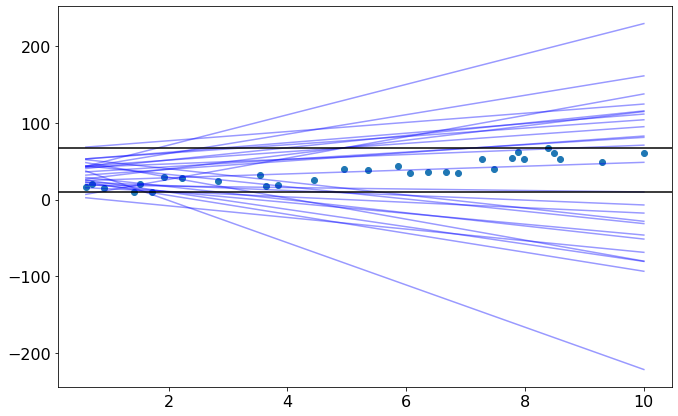

In [68]:
# see if our priors are reasonable

n_sim = 25
x_range = np.linspace(x.min(), x.max())

beta_sim = np.random.normal(0, 10, size=n_sim)
alpha_sim = np.random.normal(35, 15, size=n_sim)

for i in range(n_sim):
    plt.plot(x, alpha_sim[i] + beta_sim[i] * x, c='b', alpha=0.4)
    
plt.axhline(y.min(), c='k')
plt.axhline(y.max(), c='k')
plt.scatter(x, y)

Some of the possibilities are completely unreasonable (either way outside the range of what we observe or unphysical). We also put equal probability on positive and negative slopes (with zero slope meaning that there is no relationship between x and y). We should probably pick better priors!

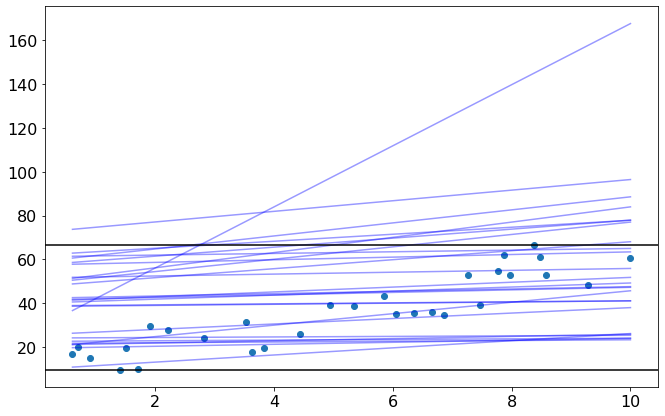

In [69]:
# see if our priors are reasonable

n_sim = 25
x_range = np.linspace(x.min(), x.max())

beta_sim = np.random.lognormal(0.1, 1, size=n_sim)
alpha_sim = np.random.normal(35, 15, size=n_sim)

for i in range(n_sim):
    plt.plot(x, alpha_sim[i] + beta_sim[i] * x, c='b', alpha=0.4)
    
plt.axhline(y.min(), c='k')
plt.axhline(y.max(), c='k')
plt.scatter(x, y)

# talk about mcmc here if there is time

In [76]:
# compile stan model
sm = cmdstanpy.CmdStanModel(stan_file = 'linreg.stan')

INFO:cmdstanpy:compiling stan program, exe file: /home/js/programs/linreg-bayes/linreg
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/js/programs/linreg-bayes/linreg


In [77]:
# prep data to be passed in to stan model
data = {
    'N': n,
    'x': x,
    'y': y,
}

In [82]:
# sample posterior
fit = sm.sample(data, chains=2, show_progress='notebook')

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [83]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-78.0,0.052,1.3,-81.0,-78.0,-77.0,660.0,17000.0,1.0
alpha,11.0,0.130,2.9,6.1,11.0,16.0,520.0,13000.0,1.0
beta,4.9,0.020,0.5,4.0,4.9,5.7,610.0,16000.0,1.0
sigma,7.7,0.039,1.1,6.1,7.6,9.8,840.0,22000.0,1.0


In [84]:
# get posterior samples
alphas = fit.stan_variable('alpha')
betas = fit.stan_variable('beta')
sigmas = fit.stan_variable('sigma')

# compare to mle estimates

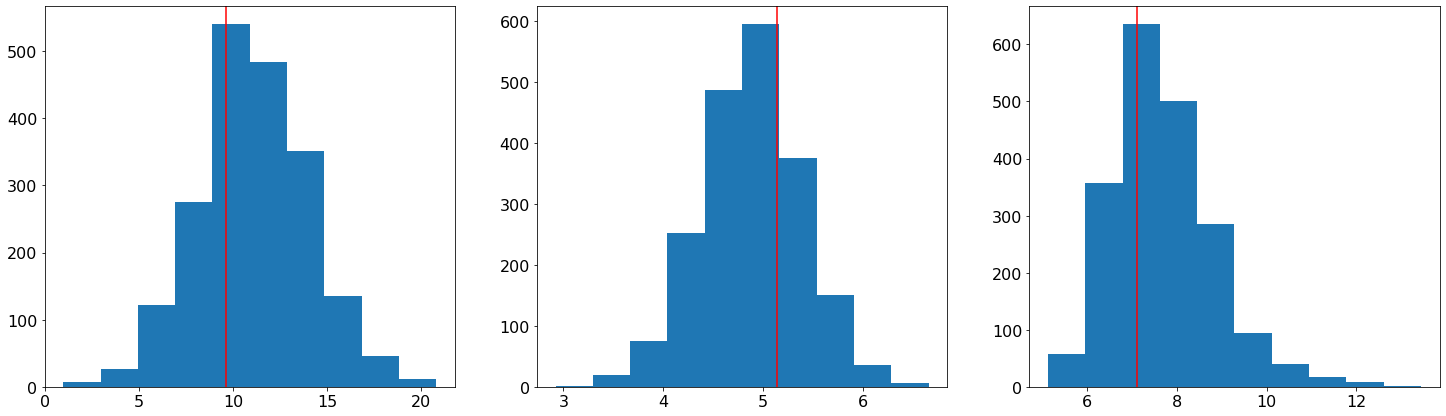

In [89]:
fig, ax = plt.subplots(1, 3, figsize=(25, 7))

# sns.distplot(alphas, ax=ax[0])
# sns.distplot(betas, ax=ax[1])
# sns.distplot(sigmas, ax=ax[2])

ax[0].hist(alphas)
ax[1].hist(betas)
ax[2].hist(sigmas)

ax[0].axvline(mle_params[1], c='r')
ax[1].axvline(mle_params[0], c='r')
ax[2].axvline(mle_params[2], c='r')


# pairs plots, kdes

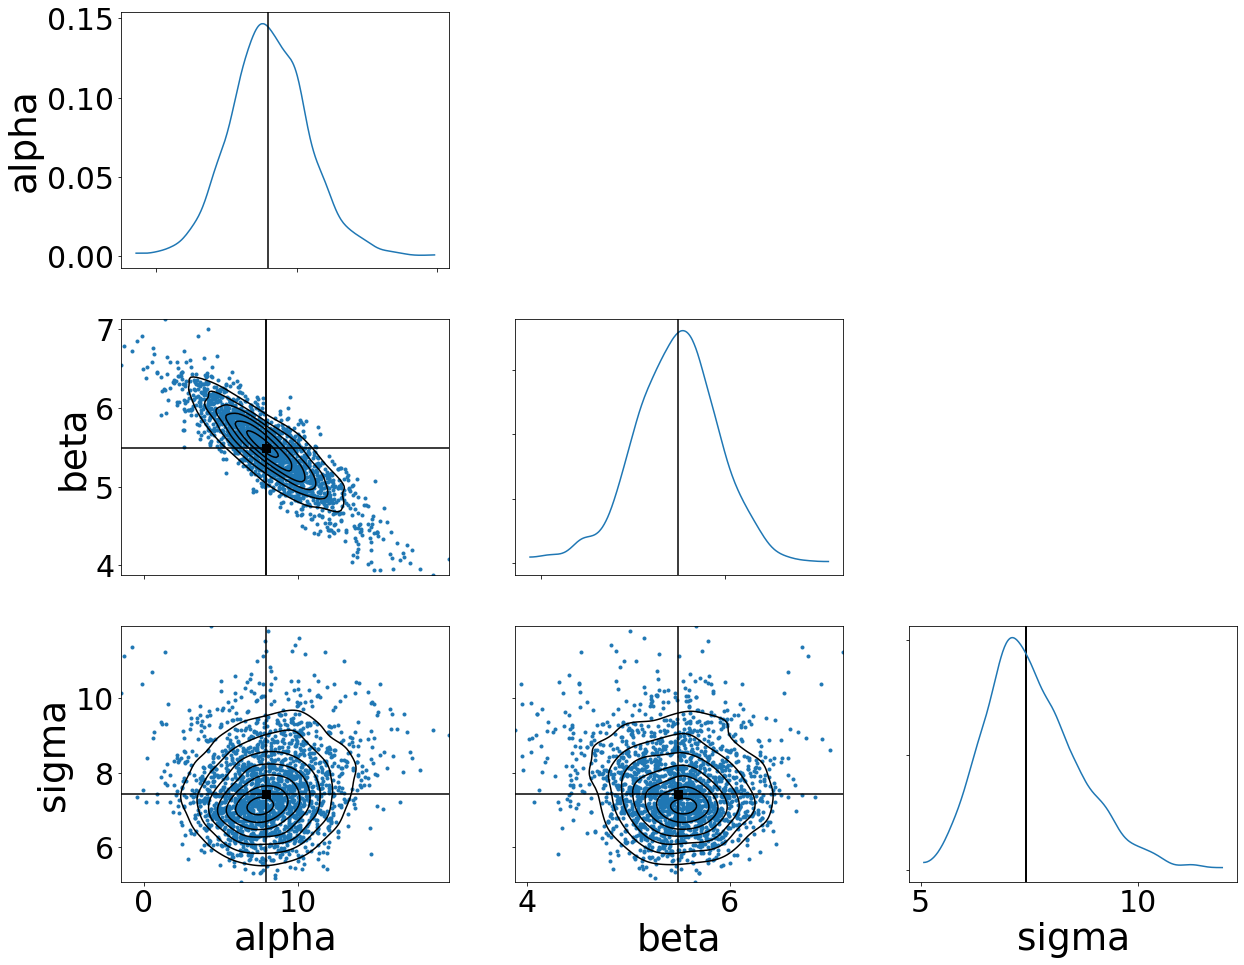

In [44]:
az.plot_pair(fit, var_names=['alpha', 'beta', 'sigma'], marginals=True, kind=['scatter', 'kde'], point_estimate='median', textsize=30, figsize=(20, 16));

# read this: https://corner.readthedocs.io/en/latest/pages/sigmas.html

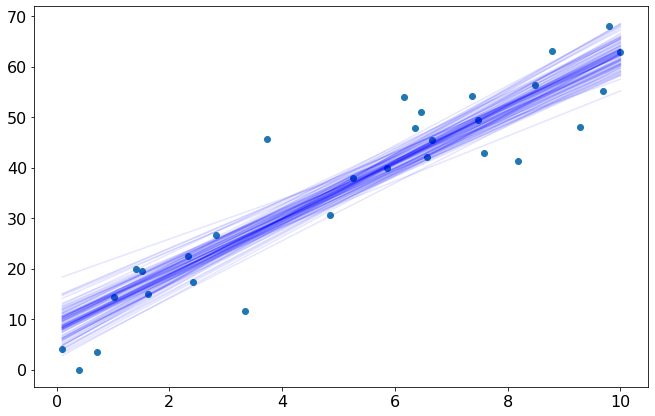

In [55]:
idx = np.random.choice(np.arange(2000), 100, replace=False)

for i in idx:
    plt.plot(x, alphas[i] + betas[i] * x, c='b', alpha=0.1)
    
plt.scatter(x, y)

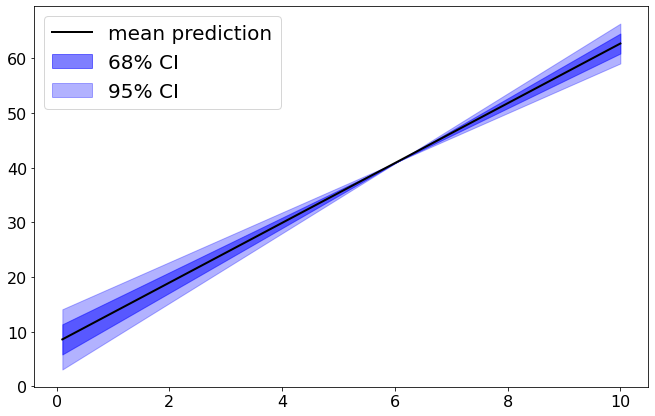

In [56]:
alpha_mean = alphas.mean()
alpha_std = alphas.std()
beta_mean = betas.mean()
beta_std = betas.std()

plt.plot(x, alpha_mean + beta_mean * x, color='k', zorder=5, lw=2, label='mean prediction')
plt.fill_between(x, (alpha_mean - alpha_std) + (beta_mean + beta_std) * x, (alpha_mean + alpha_std) + (beta_mean - beta_std) * x, alpha=0.5, color='b', label='68% CI')
plt.fill_between(x, (alpha_mean - 2 * alpha_std) + (beta_mean + 2 * beta_std) * x, (alpha_mean + 2 * alpha_std) + (beta_mean - 2 * beta_std) * x, alpha=0.3, color='b', label='95% CI')
plt.legend(fontsize=20)

# simulating fake data

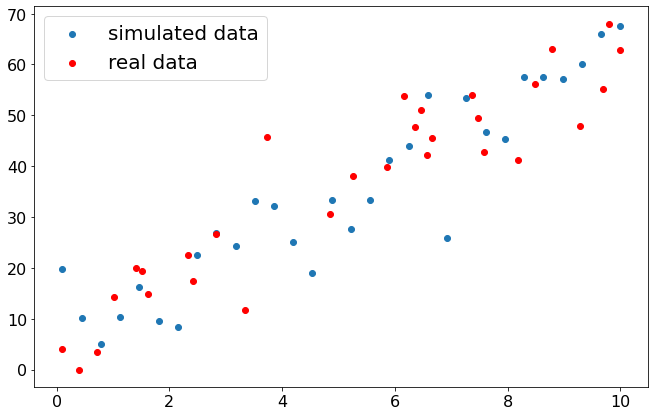

In [57]:
idx = np.random.choice(np.arange(2000), n)

x_psim = np.linspace(x.min(), x.max(), n)
mu_psim = alphas[idx] + betas[idx] * x_psim
y_psim = np.random.normal(mu_psim, sigmas[idx])

plt.scatter(x_psim, y_psim, label='simulated data')
plt.scatter(x, y, c='r', label='real data')
plt.legend(fontsize=20)

# more checks

<AxesSubplot:ylabel='Density'>

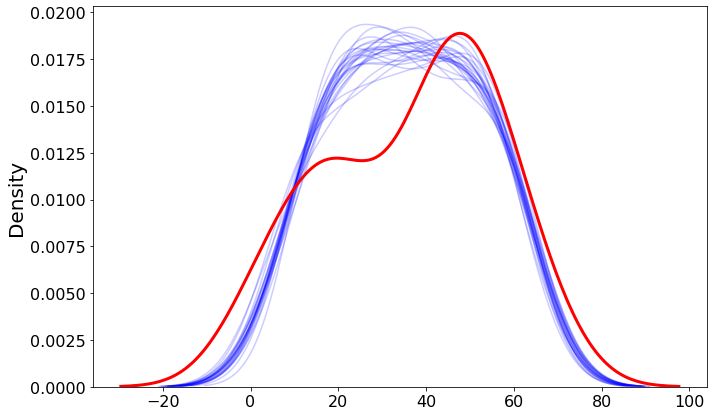

In [58]:
for i in range(n_sim):
    idx = np.random.choice(np.arange(2000), n)
    ax = sns.distplot(alphas[idx] + betas[idx] * x_psim, hist=False, color='blue')
    
for line in ax.get_lines():
    line.set_alpha(0.2)
    
sns.distplot(y, hist=False, kde_kws=dict(lw=3), color='red')

<AxesSubplot:ylabel='Proportion'>

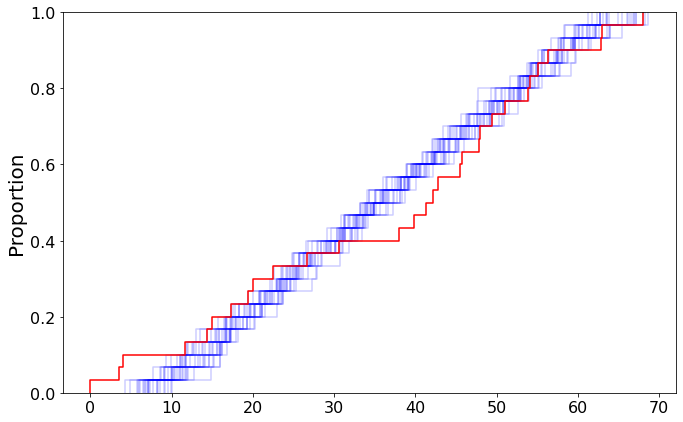

In [59]:
for i in range(n_sim):
    idx = np.random.choice(np.arange(2000), n)
    ax = sns.ecdfplot(alphas[idx] + betas[idx] * x_psim, color='blue')
    
for line in ax.get_lines():
    line.set_alpha(0.2)
    
sns.ecdfplot(y, color='red')

# what if our posterior distribution was way off?

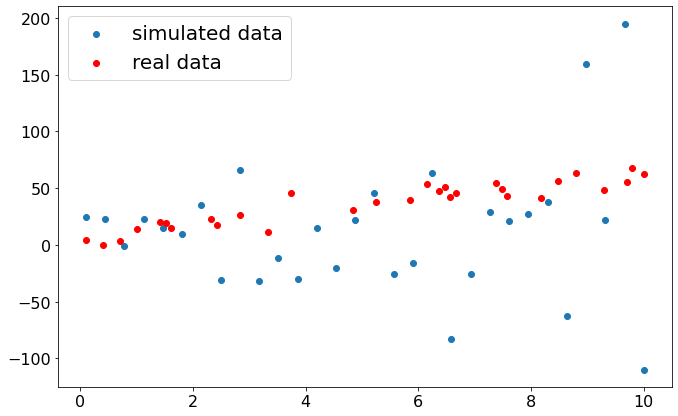

In [60]:
beta_fake = np.random.normal(0, 10, size=2000)



idx = np.random.choice(np.arange(2000), n)

x_psim = np.linspace(x.min(), x.max(), n)
mu_psim = alphas[idx] + beta_fake[idx] * x_psim
y_psim = np.random.normal(mu_psim, sigmas[idx])

plt.scatter(x_psim, y_psim, label='simulated data')
plt.scatter(x, y, c='r', label='real data')
plt.legend(fontsize=20)

<AxesSubplot:ylabel='Density'>

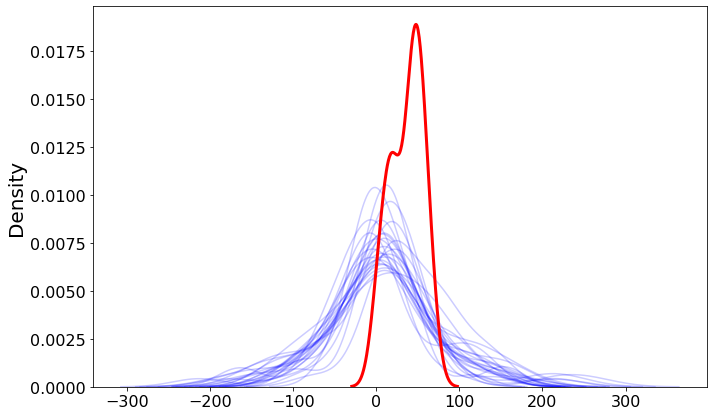

In [61]:
for i in range(n_sim):
    idx = np.random.choice(np.arange(2000), n)
    ax = sns.distplot(alphas[idx] + beta_fake[idx] * x, hist_kws=dict(alpha=0.2), hist=False, color='blue')
    
for line in ax.get_lines():
    line.set_alpha(0.2)
    
sns.distplot(y, hist=False, kde_kws=dict(lw=3), color='red')

<AxesSubplot:ylabel='Proportion'>

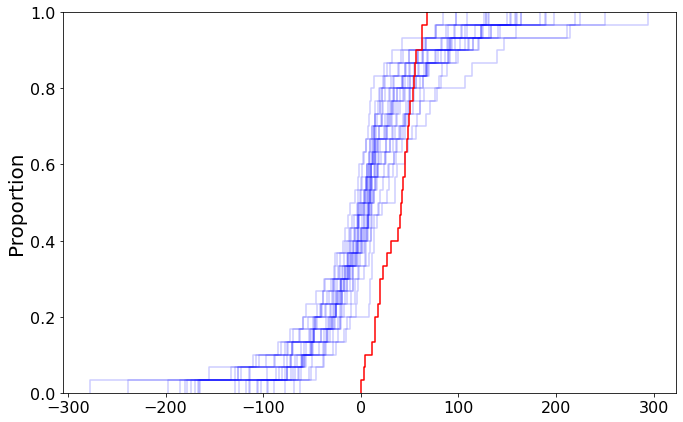

In [62]:
for i in range(n_sim):
    idx = np.random.choice(np.arange(2000), n)
    ax = sns.ecdfplot(alphas[idx] + beta_fake[idx] * x_psim, color='blue')
    
for line in ax.get_lines():
    line.set_alpha(0.2)
    
sns.ecdfplot(y, color='red')